In [1]:
import itertools
import pandas as pd
import numpy as np

import scipy as sp
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import sklearn
import sklearn.decomposition as skdecomp
import sklearn.pipeline as skpipe
import sklearn.preprocessing as skpp
import sklearn.impute as skimpute

In [2]:
class ParetoScaler(skpp.StandardScaler):
    def fit(self,X,y=None):
        self._reset()
        self.partial_fit(X,y)
        if self.scale_ is not None: self.scale_ = np.sqrt(self.scale_)
        return self

In [3]:
sklearn.__version__

'0.23.2'

In [4]:
sample_data = pd.read_excel(
    'NIH authenticity data.xlsx',
    sheet_name='Sample IDs',
    index_col=0,
)

In [5]:
colors = []#['k']
for loc in sample_data['Location'].values:
    color = 'k'
    if 'WI' in loc: color = 'r'
    if 'Wisconsin' in loc: color = 'r'
    colors += [color]
#colors

#red_dot = mpatches.Patch(facecolor='r')
red_dot = mlines.Line2D([],[],ls='none',color='r',marker='o')
#blk_dot = mpatches.Patch(facecolor='k')
blk_dot = mlines.Line2D([],[],ls='none',color='k',marker='o')

In [6]:
ginseng_data_full = pd.read_excel(
    'NIH authenticity data.xlsx',
    index_col=0,
)
ginseng_data_full

,LdGinseng,s17,s18,s19,s20,s21,s22,s23,s25,s26,s27,s28,s29,s30,s32,s33,s34,s35
Li,0.122487,NaN,NaN,0.189121,NaN,NaN,NaN,NaN,NaN,NaN,0.223775,0.313158,NaN,0.162176,0.216932,0.217907,NaN,NaN
Be,0.000155,0.003939,0.004485,0.005033,0.004554,0.002056,0.002145,0.001969,0.002864,0.003668,0.002574,0.012310,0.002118,0.001947,0.004818,0.008507,0.001308,0.003241
B,0.143098,9.095155,13.585522,15.440525,8.732032,8.563267,9.768877,10.077229,13.876611,8.104307,10.770562,19.540104,13.981989,12.261058,16.508920,9.905182,9.849860,10.702067
Na,0.553718,28.351753,30.931233,64.144929,36.469643,48.063426,19.797301,95.767486,82.043227,18.966297,13.389805,89.146927,152.138680,15.882780,30.932684,57.420891,94.337432,34.361483
Mg,0.196257,1572.558745,1382.009252,1208.879341,1417.422705,1089.046282,1016.655469,1486.646072,1393.575198,1633.358796,1235.095403,1942.978006,2497.816727,1639.118033,2460.675609,1365.913166,1429.145548,1247.400982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tl,0.000200,0.007408,0.003007,0.005136,0.008192,0.002143,0.007660,0.004933,0.007432,0.008913,0.009417,0.011374,0.005282,0.001647,0.012312,0.020563,0.003248,0.002687
Pb,0.003118,1.480007,1.280956,4.771934,0.103551,0.057432,0.076457,0.240118,0.210137,0.270094,5.477853,2.096205,1.238549,1.506073,0.131908,1.659425,2.212391,1.090034
Bi,0.000527,0.000794,0.001411,0.003229,0.001227,NaN,NaN,NaN,NaN,NaN,0.003747,0.021929,0.000735,0.001719,NaN,0.003996,0.001086,NaN
Th,0.000196,0.005630,0.004044,0.009210,0.006330,0.003155,0.003240,0.003568,0.002085,0.006414,0.008282,0.074589,0.005825,0.003821,0.008882,0.016411,0.002066,0.001869


In [7]:
ginseng_data = ginseng_data_full.T.drop('LdGinseng')
ginseng_data

,Li,Be,B,Na,Mg,Al,Si,P,S,K,...,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,Th,U
s17,NaN,0.003939,9.095155,28.351753,1572.558745,190.953168,774.713572,1762.432581,1787.678004,11716.205137,...,NaN,NaN,NaN,0.000953,0.003477,0.007408,1.480007,0.000794,0.005630,0.011604
s18,NaN,0.004485,13.585522,30.931233,1382.009252,190.750032,791.939328,2971.323842,1871.568842,16097.449975,...,0.000160,0.000056,0.000149,0.038279,0.023764,0.003007,1.280956,0.001411,0.004044,0.012130
s19,0.189121,0.005033,15.440525,64.144929,1208.879341,202.629646,702.839631,1665.805740,1555.649883,16519.253450,...,0.000143,0.000050,0.000134,0.066199,0.009993,0.005136,4.771934,0.003229,0.009210,0.030535
s20,NaN,0.004554,8.732032,36.469643,1417.422705,198.758738,820.852136,1846.280879,1607.586877,11249.171544,...,NaN,NaN,NaN,NaN,0.002726,0.008192,0.103551,0.001227,0.006330,0.011758
s21,NaN,0.002056,8.563267,48.063426,1089.046282,72.877753,247.049368,1721.953342,1702.075614,13555.302714,...,0.000149,0.000052,0.000139,0.000087,0.002393,0.002143,0.057432,NaN,0.003155,0.004911
s22,NaN,0.002145,9.768877,19.797301,1016.655469,116.991233,292.529808,1691.820927,1811.202622,12202.969478,...,0.000158,0.000055,0.000147,0.000092,0.003027,0.007660,0.076457,NaN,0.003240,0.009548
s23,NaN,0.001969,10.077229,95.767486,1486.646072,45.670995,105.792272,1399.444026,1417.331980,12503.779368,...,0.000157,0.000055,0.000146,0.000092,0.002510,0.004933,0.240118,NaN,0.003568,0.003605
s25,NaN,0.002864,13.876611,82.043227,1393.575198,98.127856,383.065549,1184.310085,1168.694078,13250.262867,...,0.000159,0.000056,0.000148,0.000772,0.003415,0.007432,0.210137,NaN,0.002085,0.008145
s26,NaN,0.003668,8.104307,18.966297,1633.358796,124.349061,448.536866,2127.668521,1720.089059,11364.773723,...,0.000165,0.000058,0.000154,0.006000,0.002284,0.008913,0.270094,NaN,0.006414,0.008228
s27,0.223775,0.002574,10.770562,13.389805,1235.095403,138.830243,284.901251,1822.092135,1997.977951,15441.695897,...,NaN,NaN,NaN,0.023671,0.008746,0.009417,5.477853,0.003747,0.008282,0.007896


In [8]:
ginseng_trimmed = ginseng_data.dropna(axis=1)

In [9]:
ginseng_trimmed

,Be,B,Na,Mg,Al,Si,P,S,K,Ca,...,Er,Yb,Hf,Ta,W,Hg,Tl,Pb,Th,U
s17,0.003939,9.095155,28.351753,1572.558745,190.953168,774.713572,1762.432581,1787.678004,11716.205137,1522.293340,...,0.003678,0.003763,0.027079,0.006040,0.110490,0.003477,0.007408,1.480007,0.005630,0.011604
s18,0.004485,13.585522,30.931233,1382.009252,190.750032,791.939328,2971.323842,1871.568842,16097.449975,2272.090763,...,0.001742,0.001663,0.019033,0.017435,0.979533,0.023764,0.003007,1.280956,0.004044,0.012130
s19,0.005033,15.440525,64.144929,1208.879341,202.629646,702.839631,1665.805740,1555.649883,16519.253450,1393.958764,...,0.005606,0.005697,0.018518,0.007772,0.255180,0.009993,0.005136,4.771934,0.009210,0.030535
s20,0.004554,8.732032,36.469643,1417.422705,198.758738,820.852136,1846.280879,1607.586877,11249.171544,1322.946219,...,0.004302,0.004385,0.024460,0.004721,0.018258,0.002726,0.008192,0.103551,0.006330,0.011758
s21,0.002056,8.563267,48.063426,1089.046282,72.877753,247.049368,1721.953342,1702.075614,13555.302714,1110.385420,...,0.000995,0.000780,0.004738,0.001513,0.005877,0.002393,0.002143,0.057432,0.003155,0.004911
s22,0.002145,9.768877,19.797301,1016.655469,116.991233,292.529808,1691.820927,1811.202622,12202.969478,1573.780696,...,0.000859,0.000749,0.006236,0.001806,0.005856,0.003027,0.007660,0.076457,0.003240,0.009548
s23,0.001969,10.077229,95.767486,1486.646072,45.670995,105.792272,1399.444026,1417.331980,12503.779368,1298.659304,...,0.001379,0.000729,0.001469,0.000854,0.003810,0.002510,0.004933,0.240118,0.003568,0.003605
s25,0.002864,13.876611,82.043227,1393.575198,98.127856,383.065549,1184.310085,1168.694078,13250.262867,1511.844968,...,0.002574,0.001809,0.006502,0.001661,0.007149,0.003415,0.007432,0.210137,0.002085,0.008145
s26,0.003668,8.104307,18.966297,1633.358796,124.349061,448.536866,2127.668521,1720.089059,11364.773723,1329.267870,...,0.001770,0.001512,0.011505,0.003135,0.016789,0.002284,0.008913,0.270094,0.006414,0.008228
s27,0.002574,10.770562,13.389805,1235.095403,138.830243,284.901251,1822.092135,1997.977951,15441.695897,2103.390471,...,0.000846,0.000732,0.007388,0.004437,0.196289,0.008746,0.009417,5.477853,0.008282,0.007896


In [10]:
ginseng_trimmed.shape

(17, 55)

In [11]:
scaled_pca = skpipe.Pipeline(
    (
        ('Scaling',skpp.StandardScaler()),
        #('Scaling',ParetoScaler(
            #with_std=False,
        #)),
        ('PCA',skdecomp.PCA(n_components=8),
        )
    )
)

In [12]:
nco=8
scaled_pca_pareto = skpipe.Pipeline(
    (
        #('Scaling',skpp.StandardScaler()),
        ('Scaling',ParetoScaler(
            #with_std=False,
        )),
        ('PCA',skdecomp.PCA(n_components=8),
        )
    )
)

In [13]:
scaled_pca.fit(ginseng_trimmed.values)

Pipeline(steps=[('Scaling', StandardScaler()), ('PCA', PCA(n_components=8))])

Text(0, 0.5, 'Explained variance ratio')

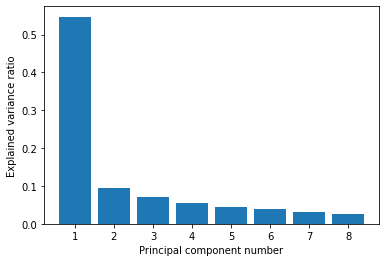

In [14]:
evr = scaled_pca.named_steps['PCA'].explained_variance_ratio_
fig,ax = plt.subplots()
plt.bar(np.arange(nco)+1,evr)
ax.set_xlabel('Principal component number')
ax.set_ylabel('Explained variance ratio')

In [15]:
scores = scaled_pca.transform(ginseng_trimmed.values)

In [16]:
label_format = 'PC {} ({:4.1f} %)'
def plot_scores(pc1,pc2,scores,evr,colors,ax,leg=False,ellipses=False):
    ax.scatter(
        scores[:,pc1],scores[:,pc2],
        c=colors)
    xlb = label_format.format(pc1+1,evr[pc1]*100)
    ylb = label_format.format(pc2+1,evr[pc2]*100)
    ax.set_xlabel(xlb)
    ax.set_ylabel(ylb)
    if leg:ax.legend([red_dot,blk_dot],['Wisconsin','Ontario'])
    
    if ellipses:
        f_alphas = np.linspace(0.05,0.95,5)
        
        colors_array = np.array(colors)
        for color in colors_array:
            class_mask = colors_array==color
            pca_samples = np.count_nonzero(class_mask)

            x_sc = scores[class_mask,pc1]
            y_sc = scores[class_mask,pc2]

            on_cov = np.cov(x_sc,y_sc)

            lam,v = np.linalg.eigh(on_cov)
            lam = np.sqrt(lam)
            theta = np.degrees(np.arctan2(*v[:,0][::-1]))

            df1 = 2
            df2 = pca_samples - df1

            Hoetelling_mult = df1*(pca_samples-1)/(df2)

            xy_tuple = (np.mean(x_sc),np.mean(y_sc))

            T_center = np.array([xy_tuple])

            for alpha in f_alphas:
                #print(alpha)
                F_val = sp.stats.f.isf(alpha,df1,df2)
                F_mult = F_val * Hoetelling_mult
                F_mult = np.sqrt(F_mult)
                #print(F_mult)

                ellipse_dict = dict(xy=xy_tuple,
                                    width=lam[0]*2*F_mult,height=lam[1]*2*F_mult,
                                    angle=theta,linewidth=1,linestyle=':',zorder=2,facecolor='none',edgecolor=color)
                ell = mpatches.Ellipse(**ellipse_dict)
                ax.add_artist(ell)

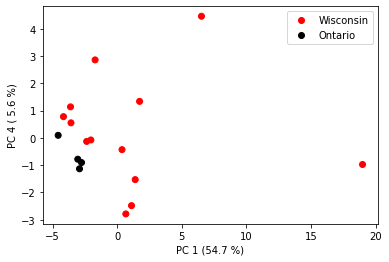

In [17]:
fig,ax = plt.subplots()
plot_scores(0,3,scores,evr,colors,ax,leg=True)

In [18]:
on_mask = np.array(colors)=='k'
wi_mask = ~on_mask

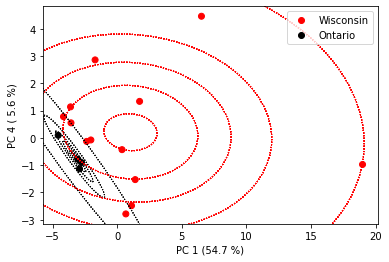

In [19]:
fig,ax = plt.subplots()
plot_scores(0,3,scores,evr,colors,ax,leg=True,ellipses=True)

# f_alphas = np.linspace(0.05,0.95,5)

# colors_array = np.array(colors)
# for color in np.unique(colors_array):
#     class_mask = colors_array==color
#     pca_samples = np.count_nonzero(class_mask)

#     x_sc = scores[class_mask,0]
#     y_sc = scores[class_mask,3]

#     on_cov = np.cov(x_sc,y_sc)

#     lam,v = np.linalg.eigh(on_cov)
#     lam = np.sqrt(lam)
#     theta = np.degrees(np.arctan2(*v[:,0][::-1]))

#     df1 = 2
#     df2 = pca_samples - df1

#     Hoetelling_mult = df1*(pca_samples-1)/(df2)

#     xy_tuple = (np.mean(x_sc),np.mean(y_sc))

#     T_center = np.array([xy_tuple])

#     for alpha in f_alphas:
#         #print(alpha)
#         F_val = sp.stats.f.isf(alpha,df1,df2)
#         F_mult = F_val * Hoetelling_mult
#         F_mult = np.sqrt(F_mult)
#         #print(F_mult)

#         ellipse_dict = dict(xy=xy_tuple,
#                             width=lam[0]*2*F_mult,height=lam[1]*2*F_mult,
#                             angle=theta,linewidth=1,linestyle=':',zorder=2,facecolor='none',edgecolor=color)
#         ell = mpatches.Ellipse(**ellipse_dict)
#         ax.add_artist(ell)

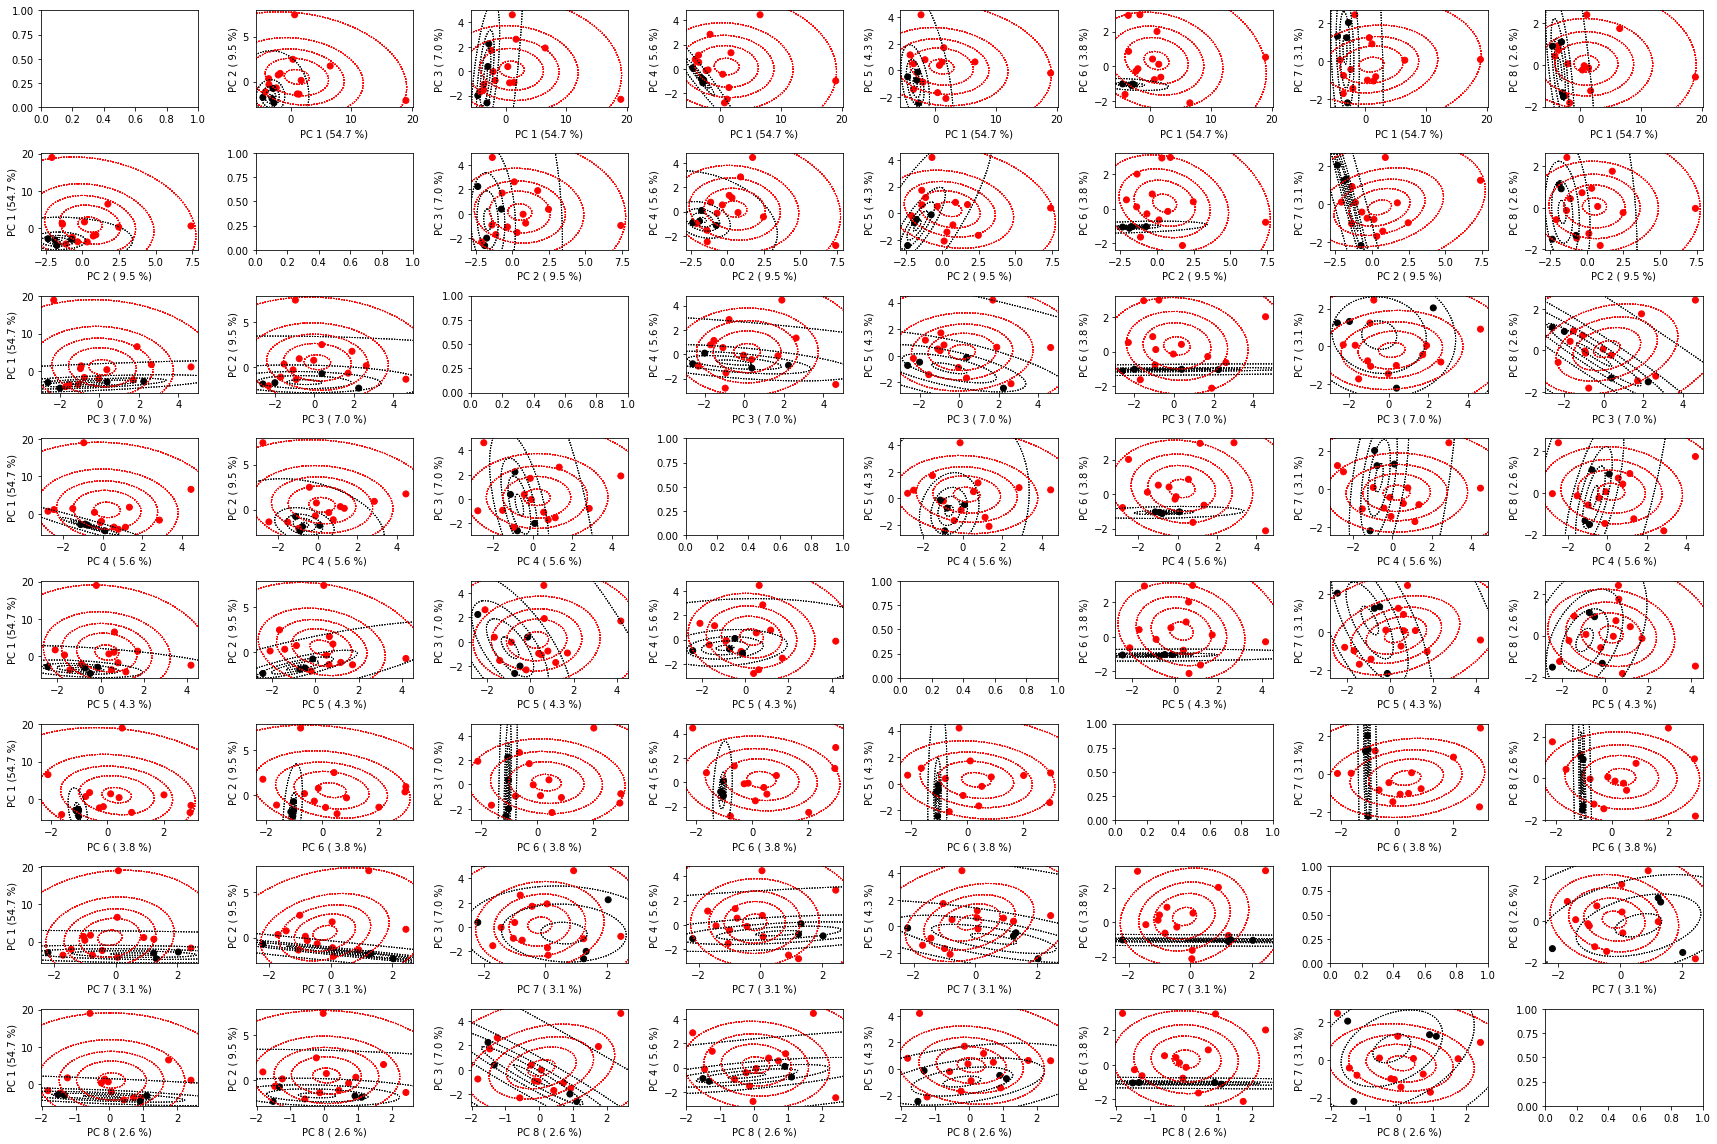

In [20]:
fig,axs = plt.subplots(
    nco,nco,
    figsize=(24,16),
    #sharex='col',sharey='row',
    facecolor='w',
)

for pc1,pc2 in itertools.permutations(
    np.arange(nco),
    #np.arange(5),
    2
):
    ax = axs[pc1,pc2]
    plot_scores(pc1,pc2,scores,evr,colors,ax,ellipses=True)
fig.tight_layout()

In [21]:
comps = scaled_pca.named_steps['PCA'].components_

In [22]:
comps.shape

(8, 55)

Text(0.5, 0, 'Elemental component index')

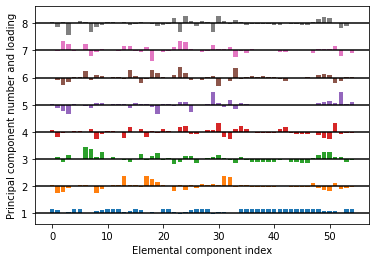

In [23]:
fig,ax=plt.subplots(figsize=(6,4))

for num,comp in enumerate(comps):
    ax.bar(
        np.arange(comps.shape[1]),# + num/(comps.shape[0]),
        comp,
        bottom=num+1,
        #width=1/(comps.shape[0])
    )
for x in np.arange(comps.shape[0]):
    plt.axhline(x+1, color='k')
    
ax.set_ylabel('Principal component number and loading')
ax.set_xlabel('Elemental component index')

In [24]:
sorted_index = np.argsort(comps[0,:]**2)[::-1]
sorted_index

array([21, 10,  4, 12, 15, 28,  0, 11,  5, 39, 36, 40, 37, 43, 38, 44, 45,
       46, 26, 53, 47, 41, 27, 35, 20, 34, 42, 48, 54, 25, 16,  9,  1,  8,
       51, 50, 14, 49, 22, 31, 30, 24,  3, 18, 13, 17, 19, 52,  7, 33, 32,
        2, 23,  6, 29])

In [25]:
ginseng_data.columns.values[sorted_index]

array(['Ga', 'Ca', 'Mg', 'Ti', 'Mn', 'Y', 'Li', 'Sc', 'Al', 'Te', 'In',
       'I', 'Sn', 'La', 'Sb', 'Ce', 'Pr', 'Nd', 'Rb', 'Er', 'Sm', 'Cs',
       'Sr', 'Cd', 'Zn', 'Ag', 'Ba', 'Eu', 'Tm', 'Br', 'Fe', 'K', 'Be',
       'S', 'Dy', 'Tb', 'Cr', 'Gd', 'Ge', 'Mo', 'Nb', 'Se', 'Na', 'Ni',
       'V', 'Co', 'Cu', 'Ho', 'P', 'Pd', 'Ru', 'B', 'As', 'Si', 'Zr'],
      dtype=object)

In [26]:
imputer = skimpute.SimpleImputer()


In [27]:
ginseng_data_filled = ginseng_data.fillna(ginseng_data_full['LdGinseng']/2)

In [28]:
nco=8
scaled_pca_full = skpipe.Pipeline(
    (
        #('Imputer',skimpute.SimpleImputer()),
        ('Scaling',skpp.StandardScaler()),
        #('Scaling',ParetoScaler()),
        ('PCA',skdecomp.PCA(n_components=nco),
        )
    )
)

In [29]:
scaled_pca_full.fit(ginseng_data_filled.values)

Pipeline(steps=[('Scaling', StandardScaler()), ('PCA', PCA(n_components=8))])

In [30]:
scores_full = scaled_pca_full.transform(ginseng_data_filled.values)
evr_full = scaled_pca_full.named_steps['PCA'].explained_variance_ratio_

Text(0, 0.5, 'Explained variance ratio')

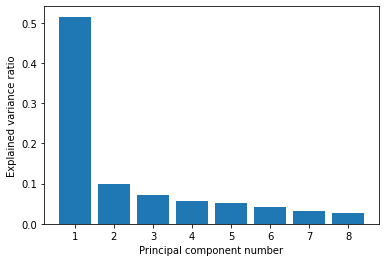

In [31]:
fig,ax = plt.subplots()
plt.bar(np.arange(nco)+1,evr_full)
ax.set_xlabel('Principal component number')
ax.set_ylabel('Explained variance ratio')

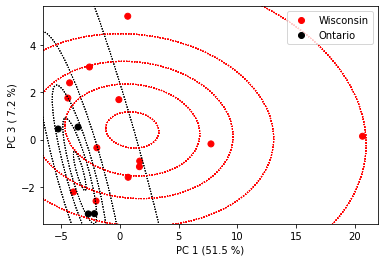

In [32]:
fig,ax = plt.subplots()
plot_scores(0,2,scores_full,evr_full,colors,ax,leg=True,ellipses=True)

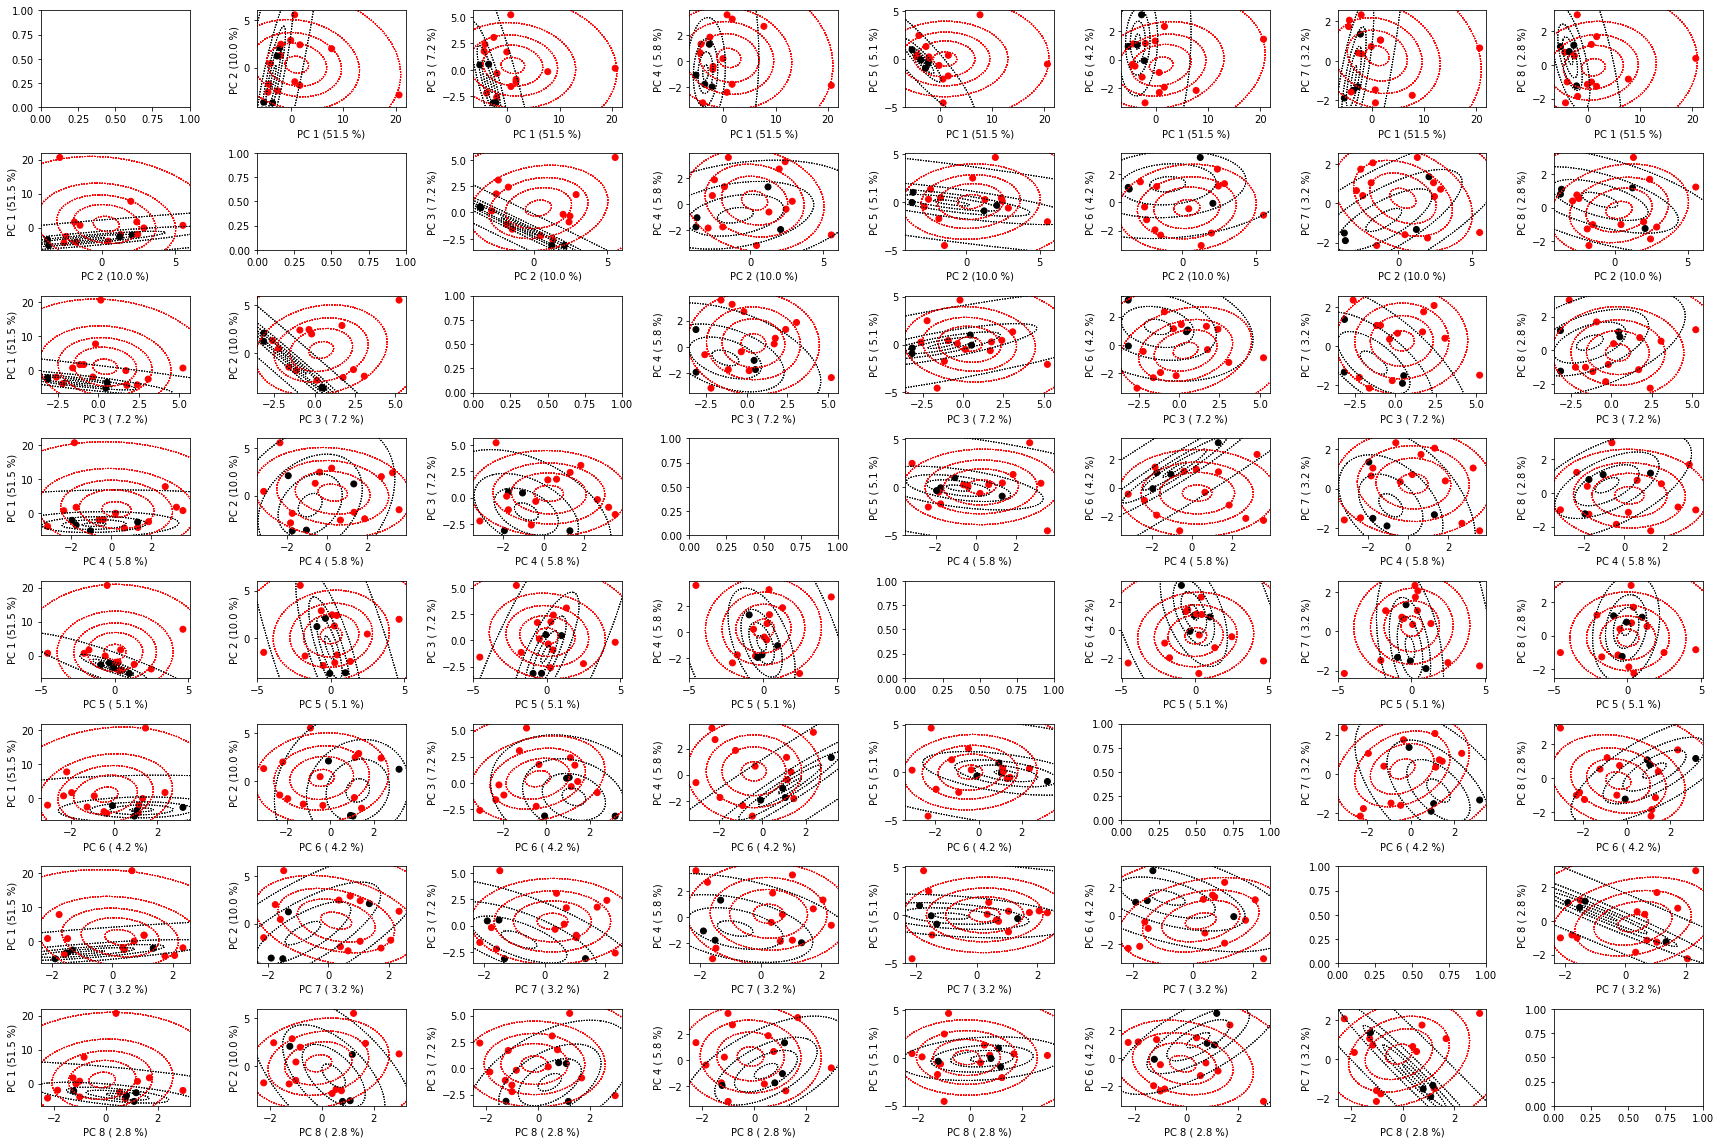

In [33]:
fig,axs = plt.subplots(
    nco,nco,
    figsize=(24,16),
    #sharex='col',sharey='row',
    facecolor='w',
)

for pc1,pc2 in itertools.permutations(
    np.arange(nco),
    #np.arange(5),
    2
):
    ax = axs[pc1,pc2]
    plot_scores(
        pc1,
        pc2,
        scores_full,
        evr_full,
        colors,
        ax,
        ellipses=True
    )
fig.tight_layout()

In [34]:
comps_full = scaled_pca_full.named_steps['PCA'].components_

Text(0.5, 0, 'Elemental component index')

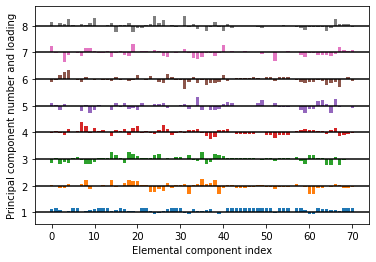

In [35]:
fig,ax=plt.subplots(figsize=(6,4))

for num,comp in enumerate(comps_full):
    ax.bar(
        np.arange(comps_full.shape[1]),# + num/(comps.shape[0]),
        comp,
        bottom=num+1,
        #width=1/(comps.shape[0])
    )
for x in np.arange(comps_full.shape[0]):
    plt.axhline(x+1, color='k')
    
ax.set_ylabel('Principal component number and loading')
ax.set_xlabel('Elemental component index')

In [36]:
sorted_index_full = np.argsort(comps_full[0,:]**2)[::-1]
sorted_index_full

array([22, 11,  5, 13, 16, 30,  1, 12,  6, 46, 47, 43, 44, 50, 51, 54, 45,
       53, 55, 28, 48, 69, 57, 29, 42, 68, 21, 49, 41, 62, 58, 70, 63, 17,
       27,  0, 33, 10, 64, 37,  2, 36,  9, 66, 65, 15, 59, 23, 60, 39, 61,
       32, 24, 34, 35,  4, 26, 19, 14, 67, 52,  8, 18, 20, 25, 38,  3, 40,
        7, 31, 56])

Text(0.5, 0, 'Elemental component index')

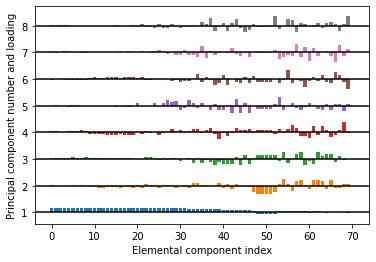

In [37]:
fig,ax=plt.subplots(figsize=(6,4))

for num,comp in enumerate(comps_full):
    ax.bar(
        np.arange(comps_full.shape[1]),# + num/(comps.shape[0]),
        comp[sorted_index_full],
        bottom=num+1,
        #width=1/(comps.shape[0])
    )
for x in np.arange(comps_full.shape[0]):
    plt.axhline(x+1, color='k')
    
ax.set_ylabel('Principal component number and loading')
ax.set_xlabel('Elemental component index')

In [38]:
ginseng_data_filled.columns.values[sorted_index_full]

array(['Ge', 'Sc', 'Al', 'V', 'Fe', 'Nb', 'Be', 'Ti', 'Si', 'Nd', 'Sm',
       'La', 'Ce', 'Tb', 'Dy', 'Tm', 'Pr', 'Er', 'Yb', 'Y', 'Eu', 'Th',
       'Hf', 'Zr', 'Ba', 'Bi', 'Ga', 'Gd', 'Cs', 'Ir', 'Ta', 'U', 'Pt',
       'Co', 'Sr', 'Li', 'Pd', 'Ca', 'Au', 'Sn', 'B', 'In', 'K', 'Tl',
       'Hg', 'Mn', 'W', 'As', 'Re', 'Te', 'Os', 'Ru', 'Se', 'Ag', 'Cd',
       'Mg', 'Rb', 'Cu', 'Cr', 'Pb', 'Ho', 'S', 'Ni', 'Zn', 'Br', 'Sb',
       'Na', 'I', 'P', 'Mo', 'Lu'], dtype=object)

In [39]:
np.linalg.eigh(np.cov(scores[on_mask].T))

(array([-9.68174084e-16, -6.90274630e-16,  4.51119587e-18,  4.10299655e-16,
         1.43445745e-15,  5.91185632e-01,  4.77223791e+00,  7.70803285e+00]),
 array([[-0.4999997 ,  0.18962817, -0.01418385,  0.09405342,  0.02288588,
         -0.81485777, -0.03155619, -0.19869952],
        [ 0.00939943,  0.3073993 ,  0.01548623,  0.31762408, -0.83703279,
          0.09197322, -0.30850881, -0.00563731],
        [-0.01208618,  0.04723256, -0.02431414,  0.49097057,  0.18549334,
          0.26862133,  0.14225434, -0.79320756],
        [-0.85775398, -0.07222278, -0.10051335, -0.07387966, -0.04611287,
          0.46694677,  0.08276933,  0.12831369],
        [-0.00510423,  0.74006213, -0.06039395,  0.10515916,  0.46870075,
          0.16582437, -0.38354499,  0.20806545],
        [-0.09413452,  0.04462234,  0.99235273, -0.00942868,  0.03805337,
          0.05265019, -0.00573076, -0.00646195],
        [ 0.06960335,  0.48547316, -0.00407305, -0.00222576, -0.13574627,
         -0.00224033,  0.84831292,

In [40]:
np.linalg.eigh(np.cov(scores[wi_mask].T))

(array([ 0.48667198,  1.1846556 ,  2.26884158,  3.08875774,  4.13118451,
         4.28313726,  6.41771916, 38.00660538]),
 array([[-0.07359938, -0.00935144, -0.03785489,  0.00242814,  0.02414353,
          0.01890561,  0.0459289 , -0.99499095],
        [-0.27091204, -0.04579246, -0.12516204,  0.03739154,  0.12716431,
          0.07370061,  0.93834777,  0.07312308],
        [-0.09440187,  0.2332363 , -0.1341165 , -0.15090927,  0.35286783,
          0.86568023, -0.14572907,  0.02780917],
        [-0.13560529, -0.10152465, -0.16558704,  0.06997537,  0.8745857 ,
         -0.38494888, -0.15914056,  0.0240171 ],
        [-0.42301689, -0.19272587, -0.20842064,  0.81079664, -0.16131931,
          0.14854684, -0.18405426,  0.03342207],
        [-0.39544439, -0.1127066 , -0.70435036, -0.47779476, -0.25496092,
         -0.12830741, -0.15308736,  0.04025048],
        [ 0.74732226, -0.16419312, -0.58944544,  0.21589058,  0.02496674,
          0.0815711 ,  0.11255724, -0.02343221],
        [ 0.00889

In [41]:
np.count_nonzero(on_mask)

4

<IPython.core.display.Javascript object>


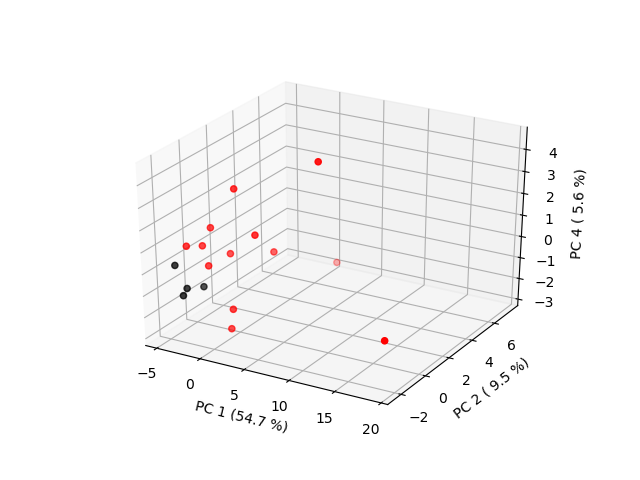

Text(0.5, 0, 'PC 4 ( 5.6 %)')

In [42]:
%matplotlib notebook

fig1,ax1=plt.subplots(subplot_kw=dict(projection='3d'))
ax1.scatter(
    scores[:,0],
    scores[:,1],
    scores[:,3],
    c=colors
)

ax1.set_xlabel(label_format.format(1,100*evr[0]))
ax1.set_ylabel(label_format.format(2,100*evr[1]))
ax1.set_zlabel(label_format.format(4,100*evr[3]))

<IPython.core.display.Javascript object>


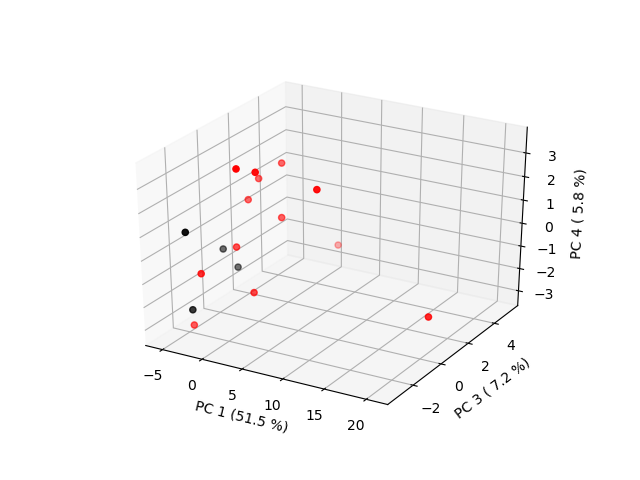

Text(0.5, 0, 'PC 4 ( 5.8 %)')

In [43]:
#%matplotlib notebook

fig2,ax2=plt.subplots(subplot_kw=dict(projection='3d'))
ax2.scatter(
    scores_full[:,0],
    scores_full[:,2],
    scores_full[:,3],
    c=colors
)

ax2.set_xlabel(label_format.format(1,100*evr_full[0]))
ax2.set_ylabel(label_format.format(3,100*evr_full[2]))
ax2.set_zlabel(label_format.format(4,100*evr_full[3]))